# **Train a basic GNN model and visualize learned node embeddings.**

**Installations - PyTorch Geometric**

In [ ]:
!pip install torch_geometric

**import PyTorch Geometric and fetch the Cora dataset.**

In [2]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
from torch.nn import Linear
import torch.nn as nn
from torch_geometric.transforms import NormalizeFeatures

# Load the Cora dataset
dataset = Planetoid(root='data/Cora', name='Cora', transform=NormalizeFeatures())
data = dataset[0]

Processing...
Done!


**Define & init model.**

In [3]:
# GNN model
class GNN(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes):
        super().__init__()
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.out = Linear(hidden_channels, num_classes)

    def forward(self, x, edge_index):
        # First Graph Convolution Layer
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)

        # Second Graph Convolution Layer
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)

        # Output layer
        x = self.out(x)
        return F.log_softmax(x, dim=1)

# init
model = GNN(num_features=dataset.num_features,
            hidden_channels=64,
            num_classes=dataset.num_classes)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


**call trainer - loop over train and eval function**

In [4]:
# train function
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss

# eval function
@torch.no_grad()
def test():
    model.eval()
    out = model(data.x, data.edge_index)

    # Training accuracy
    pred = out.argmax(dim=1)
    train_correct = pred[data.train_mask] == data.y[data.train_mask]
    train_acc = int(train_correct.sum()) / int(data.train_mask.sum())

    # Test accuracy
    test_correct = pred[data.test_mask] == data.y[data.test_mask]
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum())

    return train_acc, test_acc

# loop
best_test_acc = 0
for epoch in range(1, 101):
    loss = train()
    train_acc, test_acc = test()
    if test_acc > best_test_acc:
        best_test_acc = test_acc

    if epoch % 10 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

print(f'Best Test Accuracy: {best_test_acc:.4f}')

Epoch: 010, Loss: 1.8231, Train Acc: 0.7357, Test Acc: 0.4650
Epoch: 020, Loss: 1.1478, Train Acc: 0.9429, Test Acc: 0.7050
Epoch: 030, Loss: 0.4526, Train Acc: 0.9929, Test Acc: 0.7930
Epoch: 040, Loss: 0.1729, Train Acc: 1.0000, Test Acc: 0.7980
Epoch: 050, Loss: 0.0590, Train Acc: 1.0000, Test Acc: 0.7970
Epoch: 060, Loss: 0.0296, Train Acc: 1.0000, Test Acc: 0.7770
Epoch: 070, Loss: 0.0190, Train Acc: 1.0000, Test Acc: 0.7860
Epoch: 080, Loss: 0.0150, Train Acc: 1.0000, Test Acc: 0.7880
Epoch: 090, Loss: 0.0101, Train Acc: 1.0000, Test Acc: 0.7820
Epoch: 100, Loss: 0.0235, Train Acc: 1.0000, Test Acc: 0.7840
Best Test Accuracy: 0.8080


**Visualize learned NODE embeddings**

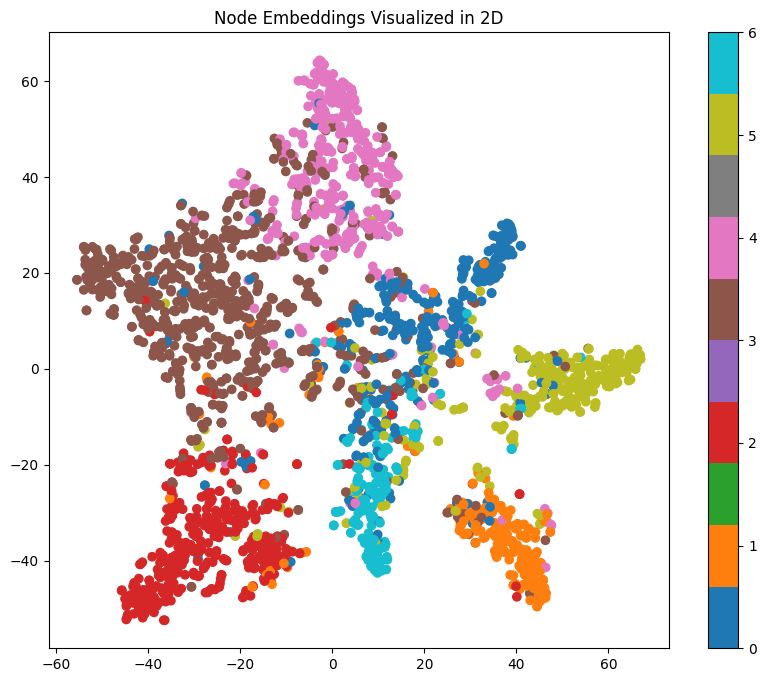

In [5]:

# Visualize learned NODE embeddings
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

@torch.no_grad()
def visualize_embeddings():
    model.eval()
    # Get embeddings from the second-to-last layer
    embeddings = model.conv2(
        model.conv1(data.x, data.edge_index).relu(),
        data.edge_index
    ).cpu().numpy()

    # Reduce dimensionality for visualization
    tsne = TSNE(n_components=2, random_state=42)
    node_embeddings_2d = tsne.fit_transform(embeddings)

    # Plot
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(node_embeddings_2d[:, 0], node_embeddings_2d[:, 1],
                         c=data.y.cpu().numpy(), cmap='tab10')
    plt.colorbar(scatter)
    plt.title('Node Embeddings Visualized in 2D')
    plt.show()

visualize_embeddings()

Advanced Implementation - Practical implementation using PyTorch Geometric and the Cora dataset.